In [25]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

### Helper functions that are used in the rest of the notebook

In [26]:
def extract_nodes(df):
    """
    Extracts the nodes from a dataframe
    :param df: dataframe with source and target columns
    :return: set of nodes
    """
    return set(df['source'].unique()).union(set(df['target'].unique()))

def load_nodes(file_path):
    """
    Loads the nodes from a file
    :param file_path: path to the file
    :return: set of nodes
    """
    # much faster to do the operations on dataframes
    df = pd.read_csv(file_path, delimiter = ' ', names=['source', 'target', 'day'])
    nodes = extract_nodes(df)
    print(f"loaded {file_path} has {len(nodes)} nodes")
    return nodes

def largest_connected_component(G):
    """
    Returns the largest connected component of a graph
    :param G: graph
    :return: largest connected component
    """
    # not supported for directed networks
    subgraphs = sorted(nx.connected_components(G), key=len, reverse=True)
    return G.subgraph(subgraphs[0])

def build_network(df, directed = False):
    """
    Builds a network from a dataframe
    :param df: dataframe with source and target columns
    :param directed: whether the network is directed or not
    :return: networkx graph
    """
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    # Check if exists a day column
    if "day" in df.columns:
        to_add = [(source, target, {"day": day}) for source, target, day in zip(df["source"], df["target"], df["day"])]
    else:
        to_add = zip(df["source"], df["target"])
    G.add_edges_from(to_add)
    return G

def extract_bidirectional_subnetwork(G):
    """
    creates an undirected sub network from a directed network

    that only contains the edges where both

    u -> v and v -> u

    are in the directed network. In the followers/following sense,

    This extracts the sub network where the users follow eachother.

    """
    sub_G = nx.Graph()

    for e in G.edges:
        if len(e) == 2:
            u, v = e
        else:
            u, v, _ = e
        if G.has_edge(v, u):
            sub_G.add_edge(u,v)

    return sub_G

def load_subnetwork(file_path, sub_nodes, directed = False):
    """
    Loads a network from a file and extracts a subnetwork by only keeping the nodes in sub_nodes
    :param file_path: path to the file with the network
    :param sub_nodes: set of nodes to keep
    :param directed: whether the network is directed or not
    :return: networkx graph
    """

    df = pd.read_csv(file_path, delimiter = ' ', names=['source', 'target', 'day'])
    if df['day'].isna().all():
        df.drop(columns=['day'], inplace=True)
    sub_df = df[((df['source'].isin(sub_nodes)) & (df['target'].isin(sub_nodes)))]

    return build_network(sub_df, directed)

def get_friendships(G):
    """
    Extracts the friendships from a social network defined as the subnetwork where both u -> v and v -> u are in the network
    :param G: social network
    :return: friendships network
    """

    G = extract_bidirectional_subnetwork(G.to_undirected())

    return G

def get_lcc(G, directed = False):
    """
    Returns the largest connected component of a graph
    :param G: graph
    :param directed: whether the graph is directed or not
    :return: largest connected component
    """
    lcc = largest_connected_component(G.to_undirected())

    return lcc

def get_subgraph(G, k=None, is_seed_node_most_connected=True):
    """
    Returns a subgraph of G with k nodes generated by BFS from a seed node
    :param G: graph
    :param k: number of nodes in the subgraph
    :param is_seed_node_most_connected: whether the seed node is the most connected node or a random node
    :return: subgraph
    """
    if k is None:
        k = G.number_of_nodes() // 5
    print('subgraph of: ' + str(k) + ' nodes')

    if is_seed_node_most_connected:
        seed_node = max(G.degree(), key=lambda x: x[1])[0]
    else:
        # Choosing a random node does not guarantee getting a subgraph of the desired size
        seed_node = random.choice(list(G.nodes()))
    # Initialize a queue for BFS and a set for visited nodes
    queue = [seed_node]
    visited = set([seed_node])
    # Initialize the subgraph with the starting node
    subgraph = nx.Graph()
    subgraph.add_node(seed_node)
    # While the subgraph has fewer than n nodes and the queue is not empty
    while len(subgraph) < k and queue:
        # Get the next node from the queue
        curr_node = queue.pop(0)
        # Add its neighbors that have not been visited to the queue and the subgraph
        for neighbor in G.neighbors(curr_node):
            if neighbor not in visited:
                if len(subgraph) >= k:
                    break
                visited.add(neighbor)
                subgraph.add_node(neighbor)
                subgraph.add_edge(curr_node, neighbor, day=G[curr_node][neighbor]["day"])
                queue.append(neighbor)
    return subgraph


### Create the dataset of replies, mentions and retweets with real timestamps (not just days)

In [27]:
activity_time_path = "../network-data/higgs-activity_time.txt"
activity_time = pd.read_csv(activity_time_path, delimiter = ' ', names=['source', 'target', 'time', 'type'])

In [28]:
# create high resolution timestamped datasets
reply_timestamps_file_path = "../output/reply_timestamps.edgelist"
mention_timestamps_file_path = "../output/mention_timestamps.edgelist"
retweet_timestamps_file_path = "../output/retweet_timestamps.edgelist"

activity_time[activity_time['type'] == 'RE'][['source', 'target', 'time']]\
.to_csv(reply_timestamps_file_path, sep=' ', header=False, index=False)
activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']]\
.to_csv(mention_timestamps_file_path, sep=' ', header=False, index=False)
activity_time[activity_time['type'] == 'RT'][['source', 'target', 'time']]\
.to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)

In [29]:
social_file_path = "../network-data/higgs-social_network.edgelist"

### Create the intersection of nodes across all interaction mechanisms.

In [30]:

reply_nodes = load_nodes(reply_timestamps_file_path)
mention_nodes = load_nodes(mention_timestamps_file_path)
reply_mention_nodes = reply_nodes.intersection(mention_nodes)
del reply_nodes, mention_nodes


retweet_nodes = load_nodes(retweet_timestamps_file_path)
reply_mention_retweet_nodes = reply_mention_nodes.intersection(retweet_nodes)
del reply_mention_nodes, retweet_nodes

print(f"intersected network has {len(reply_mention_retweet_nodes)} nodes")

loaded ../output/reply_timestamps.edgelist has 38918 nodes
loaded ../output/mention_timestamps.edgelist has 116408 nodes
loaded ../output/retweet_timestamps.edgelist has 256491 nodes
intersected network has 21346 nodes


### Create the social network and the friendship network

In [31]:
# following/followers is a directed network
social_network = load_subnetwork(social_file_path, reply_mention_retweet_nodes)
lcc_social_network = get_lcc(social_network)

friends_network = get_friendships(social_network)

del social_network
lcc_friends_network = get_lcc(friends_network)
del friends_network

nx.write_edgelist(lcc_friends_network, '../output/higgs-friends-lcc.edgelist')
nx.write_edgelist(lcc_social_network, '../output/higgs-social-lcc.edgelist')

### Create the subnetworks for replies, mentions and retweets bby only keeping the nodes that are present in the social network or the friendship network.

In [32]:
social_reply_network = load_subnetwork(reply_timestamps_file_path, lcc_social_network.nodes)
social_mention_network = load_subnetwork(mention_timestamps_file_path, lcc_social_network.nodes)
social_retweet_network = load_subnetwork(retweet_timestamps_file_path, lcc_social_network.nodes)

friends_reply_network = load_subnetwork(reply_timestamps_file_path, lcc_friends_network.nodes)
friends_mention_network = load_subnetwork(mention_timestamps_file_path, lcc_friends_network.nodes)
friends_retweet_network = load_subnetwork(retweet_timestamps_file_path, lcc_friends_network.nodes)

paths = ['../output/higgs-social-reply.edgelist', '../output/higgs-social-mention.edgelist', '../output/higgs-social-retweet.edgelist', '../output/higgs-friends-reply.edgelist', '../output/higgs-friends-mention.edgelist', '../output/higgs-friends-retweet.edgelist']
networks = [social_reply_network, social_mention_network, social_retweet_network, friends_reply_network, friends_mention_network, friends_retweet_network]


for path, network in zip(paths, networks):
    nx.write_edgelist(network, path)
    with open(path, 'r') as f:
        data = f.readlines()

    # Remove the "day" key from each line of data
    data = [line.strip().replace("{'day': ", "").replace("}", "") for line in data]

    # Convert the data into a list of tuples with integer values
    data = [tuple(map(int, line.split())) for line in data]

    # Write the modified data to a new file
    with open(path, 'w') as f:
        for line in data:
            f.write(f"{line[0]} {line[1]} {line[2]}\n")



In [33]:
friends_file_path = "../output/higgs-friends-lcc.edgelist"
friends_reply_path = "../output/higgs-friends-reply.edgelist"
friends_mention_path = "../output/higgs-friends-mention.edgelist"
friends_retweet_path = "../output/higgs-friends-retweet.edgelist"

### Temporal analysis of the reply network

In [34]:
G_reply = nx.read_edgelist(friends_reply_path, data=(("day", int),))
subgraph_reply = get_subgraph(G_reply, 5000)
subgraph_reply_df = pd.DataFrame(subgraph_reply.edges(data=True), columns=['source', 'target', 'attribute'])
# Extract the 'day' attribute from the 'attribute' column and add it as a separate column
subgraph_reply_df['timestamp'] = [d['day'] for d in subgraph_reply_df['attribute']]
min_t = min(subgraph_reply_df['timestamp'])

# Hardcoded normalizing to ~1000 timesteps
subgraph_reply_df['day'] = ((subgraph_reply_df['timestamp'] - min_t)/ 600).astype(int)
# Drop the 'attribute' column, which is no longer needed
subgraph_reply_df.drop('attribute', axis=1, inplace=True)

# there are days above 7, so we need to remove them
# subgraph_reply_df = subgraph_reply_df[subgraph_reply_df['day'] <= 7]
#unique_days = subgraph_reply_df['day'].unique()
#print(unique_days)

subgraph_reply_df.sort_values('day')

subgraph of: 5000 nodes


,source,target,timestamp,day
3268,213163,223789,1341100972,0
1288,677,424732,1341106079,8
4681,8425,150805,1341109596,14
3476,2288,174754,1341111247,17
3465,186184,70301,1341111839,18
...,...,...,...,...
1729,677,142154,1341701387,1000
173,88,195150,1341701308,1000
4131,9021,50244,1341701458,1000
584,15483,97296,1341705530,1007


ration 2/100 : 10/1007 --- Iteration 2/100 : 180/1007 --- Iteration 2/100 : 343/1007 --- Iteration 2/100 : 588/1007 --- Iteration 2/100 : 840/1007 --- Iteration 2/100 : 966/1007 --- Iteration 3/100 : 150/1007 --- Iteration 3/100 : 291/1007 --- Iteration 3/100 : 568/1007 --- Iteration 3/100 : 669/1007 --- Iteration 4/100 : 1/1007 --- Iteration 4/100 : 347/1007 --- Iteration 4/100 : 453/1007 --- Iteration 4/100 : 796/1007 --- Iteration 5/100 : 109/1007 --- Iteration 5/100 : 505/1007 --- Iteration 5/100 : 869/1007 --- Iteration 6/100 : 174/1007 --- Iteration 6/100 : 592/1007 --- Iteration 6/100 : 970/1007 --- Iteration 7/100 : 389/1007 --- Iteration 7/100 : 750/1007 --- Iteration 8/100 : 226/1007 --- Iteration 8/100 : 571/1007 --- Iteration 9/100 : 0/1007 --- Iteration 9/100 : 396/1007 --- Iteration 9/100 : 828/1007 --- Iteration 10/100 : 126/1007 --- Iteration 10/100 : 533/1007 --- Iteration 10/100 : 868/1007 --- Iteration 11/100 : 236/1007 --- Iteration 11/100 : 606/1007 --- Iteration 1

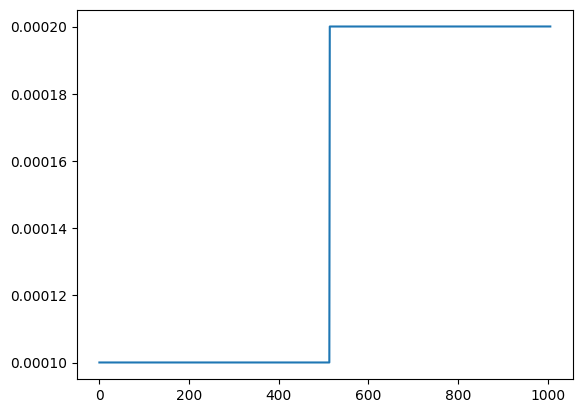

In [35]:
#  First implementation of temporal spreading
# From the plot I am not sure if this is correct, the number of infected nodes is pretty low,
# but that could be because the huge majority of interactions happen at time 1, and i am considering a node as spreader from the next day is infected
# if we remove this condition I expect the number of infected nodes to be almost the same as the number of nodes in the subgraph at day 1

subgraph_reply_df = subgraph_reply_df.sort_values(by=['day'])
subgraph_reply_df.reset_index(drop=True, inplace=True)

iterations = 100
infected_nodes_time_dict = {0:[1 for _ in range(iterations)]}
seed_nodes = []

min_day = min(subgraph_reply_df['day'])
max_day = max(subgraph_reply_df['day'])
number_of_nodes = len(subgraph_reply.nodes())
for n in range(iterations):
    seed_node = random.choice(list(subgraph_reply.nodes()))
    seed_nodes.append(seed_node)
    infected_nodes = {seed_node}

    cur_timestamp = min_day
    nodes_infected_in_timestamp = set()

    # Iterate over all days
    for day in range(min_day, max_day):
        print(f'Iteration {n+1}/{iterations} : {day}/{max_day} --- ', end='\r')
        # For each day get the edges that were created on that day
        edges = subgraph_reply_df[subgraph_reply_df['day'] == day]
        # Take the dataframe subset where either the source or the target is in the infected nodes
        susceptible_nodes_rows = edges[edges['source'].isin(infected_nodes) | edges['target'].isin(infected_nodes)]
        # Make a set of all the nodes that are in susceptible_nodes_rows
        susceptible_nodes = set(susceptible_nodes_rows['source']).union(set(susceptible_nodes_rows['target']))
        # Add the susceptible nodes to the infected nodes
        infected_nodes = infected_nodes.union(susceptible_nodes)
        # Add the infected nodes to the infected_nodes_time_dict
        if day in infected_nodes_time_dict:
            infected_nodes_time_dict[day].append(len(infected_nodes))
        else:
            infected_nodes_time_dict[day] = [len(infected_nodes)]

    # Take the average of the infected nodes for each timestamp
    infected_nodes_time_dict = {k: [np.sum(v)/(len(v)*number_of_nodes)] for k, v in infected_nodes_time_dict.items()}
    plt.clf()
    plt.plot(list(infected_nodes_time_dict.keys()), list(infected_nodes_time_dict.values()))